# Preparation

In [1]:
!pip install langdetect
!pip install googletrans==4.0.0rc1

     |████████████████████████████████| 981 kB 5.4 MB/s 
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=35a247ee87a9b02b31ebb34e132aff9e496ade06cb839b0587cc8902c69ba13d
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 55 kB 1.8 MB/s 
     |████████████████████████████████| 42 kB 1.1 MB/s 
     |████████████████████████████████| 1.3 MB 32.6 MB/s 
     |████████████████████████████████| 53 kB 1.8 MB/s 
     |████████████████████████████████| 65 kB 1.6 MB/s 
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=e0dc45a38333cc6526e5425b76bad66101d0f0e2f7e7566755421264b56b68f4
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans


In [2]:
# lib prep.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from google.colab import drive
drive.mount('/drive')
import tensorflow as tf
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image  
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as cm, \
                            classification_report as cr
import pickle
import langdetect
from googletrans import Translator

Mounted at /drive


In [3]:
# loading data
data = pd.read_csv('bbc-text.csv')

# check top-5 data
data.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


In [4]:
# check bottom-5 data
data.tail()

,category,text
2220,business,cars pull down us retail figures us retail sal...
2221,politics,kilroy unveils immigration policy ex-chatshow ...
2222,entertainment,rem announce new glasgow concert us band rem h...
2223,politics,how political squabbles snowball it s become c...
2224,sport,souness delight at euro progress boss graeme s...


In [5]:
# check data info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


# EDA

## Assumptions / Statements / Questions:

1. How is the distribution of news categories?
2. For each news category, it is easy to find certain words that often appear as a feature of that news category.
3. In general, how long are news articles?
4. Usually how many unique words are in a news article?
5. What is the ratio of unique words to news article length?
6. The length of a news article or the number of unique words does not affect the topic of the news article

## Exploratory

### 1. How is the distribution of news categories?

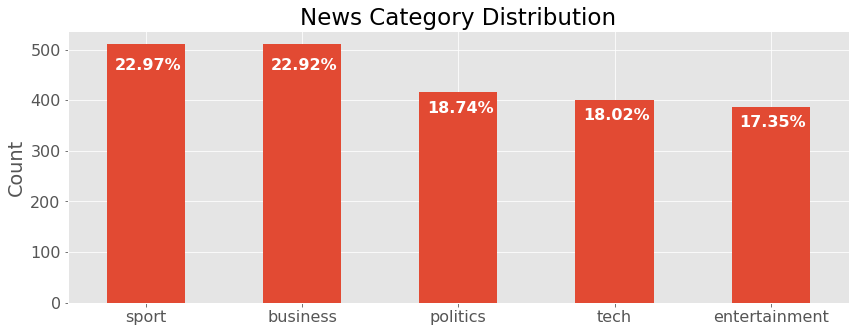

In [6]:
plt.rcParams.update({'font.size': 16})
ax = data['category'].value_counts()\
                .sort_values(ascending=False)\
                .plot(kind='bar', title='News Category Distribution', 
                      figsize=(14,5), fontsize=16, rot=0, ylabel='Count')

for i in ax.patches:  
    ax.text(i.get_x()+.05, i.get_height()*.9,
               '{:^4}%'.format(round((i.get_height()/data.shape[0])*100, 2)), 
               fontsize=16, color='white', weight='bold') 

> The news category is **spread fairly evenly** in the range of **17.35% to 22.97%**. The most category is the **sport** and the lowest is entertainment.

### 2. For each news category, it is easy to find certain words that often appear as a feature of that news category.

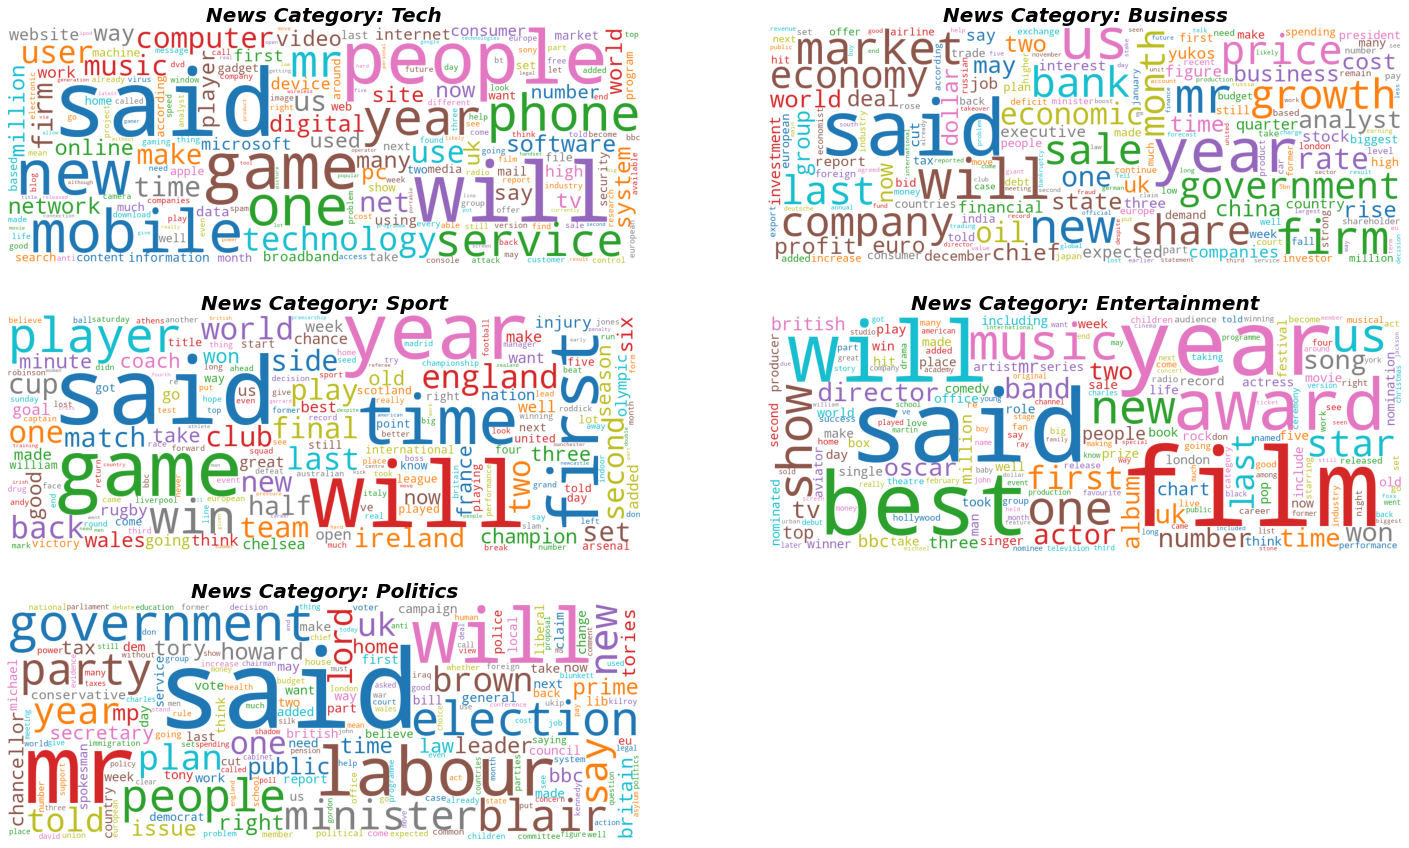

In [7]:
plt.figure(figsize=(25,15))

for i, cat in enumerate(data.category.unique()):
  plt.subplot(3,2,i+1)
  plt.title('News Category: '+cat.title(), size=20, fontstyle='italic', fontweight='bold')
  wordcloud_cat = WordCloud(width = 1200, height = 450, random_state=1, 
                            background_color='white', colormap='tab10', 
                            collocations=False)\
                            .generate(' '.join(data[data.category==cat]['text']))  
  plt.imshow(wordcloud_cat)
  plt.axis("off")

> It seems that the word _'Film'_ can be the key in the category of entertainment. But on the other hand, it is **quite difficult to determine the keywords** for other categories. This can be seen from words such as ***'Said'*** and ***'Will'*** which also **appear a lot in each category.**

### 3. In general, how long are news articles?

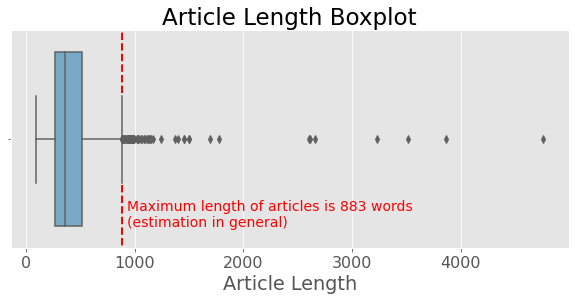

,Article Length
count,2225.000000
mean,419.757303
std,260.055935
min,94.000000
25%,268.000000
50%,361.000000
75%,514.000000
max,4759.000000


In [8]:
data['Article Length'] = data.text.apply(lambda x:len(x.split(' ')))

q3 = int(data['Article Length'].quantile(.75))
q1 = int(data['Article Length'].quantile(.25))
general_max_length = int((q3-q1)*1.5+q3)

plt.figure(figsize=(10,4))
sns.boxplot(data=data, x='Article Length', palette='Blues')\
.set(title='Article Length Boxplot')

plt.plot([general_max_length, general_max_length], [.21, .5], 'r--', linewidth=2)
plt.plot([general_max_length, general_max_length], [-.21, -.5], 'r--', linewidth=2)
plt.annotate('Maximum length of articles is {} words \n(estimation in general)'.format(general_max_length),
             [general_max_length*1.05,.4] , color='r', fontsize=14)

plt.show()

data.describe()

> A news article can be up to **4759** words long. But this might be very rare. It is **estimated generally** that the **maximum length** of news articles is **883 words**.

### 4. Usually how many unique words are in a news article?

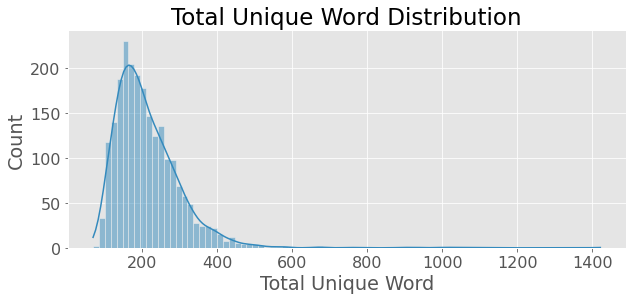

,Total Unique Word
count,2225.000000
mean,213.484944
std,91.886395
min,69.000000
25%,152.000000
50%,195.000000
75%,255.000000
max,1421.000000


In [9]:
data['Total Unique Word'] = data.text.apply(lambda x:len(set(x.split(' '))))

plt.figure(figsize=(10,4))
sns.histplot(data=data, x='Total Unique Word', palette='Blues', kde=True)\
.set(title='Total Unique Word Distribution')

plt.show()

data[['Total Unique Word']].describe()

> From the data used, the number of different words in a news article **varies from 69 to 1421 words**. The average number is **214** unique words. This is more than the **median value of 195**.  

### 5. How is the ratio of unique words to news article length?

(0.28116916709777545, 0.7686567164179104)

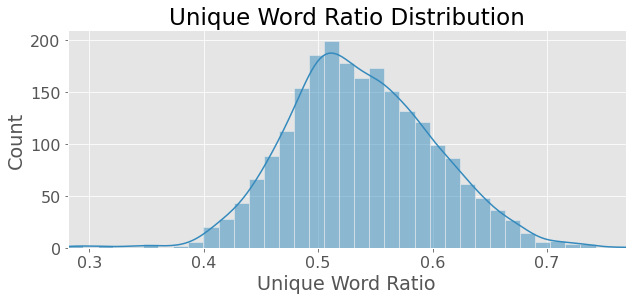

In [10]:
data['Unique Word Ratio'] = data['Total Unique Word']/data['Article Length']

plt.figure(figsize=(10,4))
sns.histplot(data=data, x='Unique Word Ratio', kde=True)\
.set(title='Unique Word Ratio Distribution')

plt.xlim(data['Unique Word Ratio'].min(),
         data['Unique Word Ratio'].max())

> The ratio of unique words to Article Length appears to be normally distributed, with the median and mean of about 50%.

### 6. The length of a news article or the number of unique words does not affect the topic of the news article

Text(0.5, 1.0, 'Heatmap of Correlation for Category')

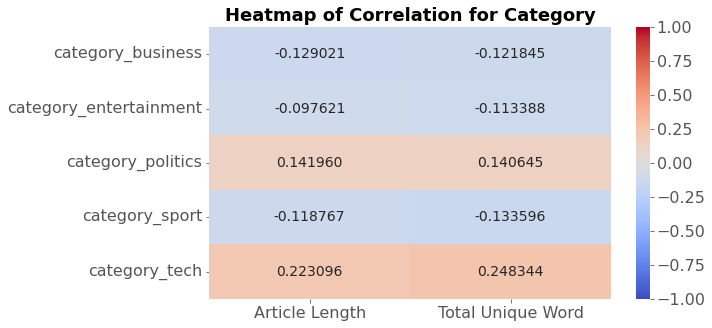

In [11]:
plt.figure(figsize=(9,5))
sns.heatmap(pd.get_dummies(data, columns=['category']).corr().iloc[3:,:2],#.iloc[3:,:3],
            annot=True ,fmt='f', cmap='coolwarm', vmin=-1, vmax=1,
            center=0, annot_kws={'size': 14})
plt.title('Heatmap of Correlation for Category', fontsize=18, fontweight='bold')

> There is **no strong impact** between news categories with the length of the article or with the number of different words in it. This is **evidenced by the correlation value**,  only in the range of **-0.129 to 0.248**.

## Summary

1. The distribution of classes in the dataset (news category) is even.
2. It is difficult to determine the keywords of each news article topic based on the frequency of their occurrence. Because many words appear in each category
3. It is estimated that, in general, the maximum length of a news article consists of 883 words.
4. The average of different words in a news article is 213 words.
5. Usually about 50% of the words in a news article are different words.
6. The length of the news article or the number of different words do not have a strong impact on determining the topic.

# Build Model

## Model Setting

In [12]:
vocab_size = 4*int(data['Total Unique Word'].max())  
embedding_dim = int(data['Total Unique Word'].mean()) 
max_length = general_max_length
padding_type='post'
trunc_type='post'
oov_tok = '<oov>'

label = data['category']
sentence = data['text']


# Split data
sentence_train, sentence_test, label_train, label_test = train_test_split(sentence, 
                                                                          label,
                                                                          stratify=label,
                                                                          test_size=0.1,
                                                                          random_state=42)

# Tokenization
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(sentence_train)

label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(label)


# Convert text to sequence
seq_sentence_train = tokenizer.texts_to_sequences(sentence_train)
seq_sentence_test = tokenizer.texts_to_sequences(sentence_test)


# Padding the sequences
padded_seq_sentence_train = pad_sequences(seq_sentence_train, padding=padding_type, maxlen=max_length, truncating=trunc_type)
padded_seq_sentence_test = pad_sequences(seq_sentence_test, padding=padding_type, maxlen=max_length, truncating=trunc_type)
label_train_seq = np.array(label_tokenizer.texts_to_sequences(label_train))
label_test_seq = np.array(label_tokenizer.texts_to_sequences(label_test))

In [13]:
print(sentence_train.shape)
print(sentence_test.shape)
print(label_train.shape)
print(label_test.shape)

(2002,)
(223,)
(2002,)
(223,)


In [14]:
print(label_tokenizer.word_index)
dict(list(tokenizer.word_index.items())[0:10])

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}


{'<oov>': 1,
 'a': 6,
 'and': 5,
 'for': 9,
 'in': 7,
 'is': 10,
 'of': 4,
 's': 8,
 'the': 2,
 'to': 3}

In [15]:
word_index = tokenizer.word_index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

lbl = ['sport', 'business', 'politics', 'tech', 'entertainment']

def decode_article(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [16]:
print(len(seq_sentence_train[2]))
print(len(padded_seq_sentence_train[2]))

print(len(seq_sentence_train[10]))
print(len(padded_seq_sentence_train[10]))
print('-----------------------------------\n')

print(seq_sentence_train[10])
print(padded_seq_sentence_train[10])
print('-----------------------------------\n')

print(decode_article(padded_seq_sentence_train[10]))
# print('-------------------------')
print(sentence_train[10:11].values[0])

290
883
470
883
-----------------------------------

[81, 1, 2953, 9, 354, 123, 6, 1, 4, 312, 21, 1907, 376, 639, 4, 6, 2147, 7, 2, 78, 1362, 123, 2, 528, 4, 1761, 5468, 1, 167, 1, 773, 1, 5, 1173, 1, 773, 1, 59, 14, 1761, 2573, 15, 3777, 1, 312, 611, 2875, 2573, 716, 23, 187, 7, 510, 19, 2, 111, 4, 48, 1273, 49, 1374, 716, 2808, 2, 1, 119, 5181, 1761, 2573, 662, 23, 1, 7, 510, 835, 3, 645, 8, 2318, 1, 2, 1, 14, 11, 2319, 9, 49, 1362, 5469, 716, 507, 41, 13, 41, 3, 3228, 104, 2, 2270, 577, 293, 153, 508, 236, 308, 28, 2, 1, 611, 2573, 716, 3, 87, 63, 1, 7, 510, 28, 1, 1295, 6, 41, 358, 1251, 312, 28, 2, 1173, 1, 773, 611, 2, 747, 4, 1761, 5470, 2319, 620, 25, 29, 428, 95, 3519, 2142, 953, 58, 22, 2, 261, 68, 64, 41, 22, 6, 1, 4541, 1645, 1, 2, 312, 205, 2526, 13, 2, 1, 4, 49, 308, 28, 1362, 475, 1, 37, 1017, 2070, 413, 1, 7, 6, 2028, 450, 5, 1, 353, 23, 44, 3, 468, 4940, 1, 1236, 217, 22, 1, 14, 5471, 36, 21, 3, 17, 42, 4721, 18, 40, 2001, 353, 3, 1, 2686, 2, 838, 2001, 552, 4, 6, 130,

In [17]:
tf.keras.backend.clear_session()
tf.random.set_seed(42)

class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy')>0.93 and (logs.get('val_accuracy') > 0.93) \
           and logs.get('loss')<0.05 and (logs.get('val_loss')<0.05):
            print('\n\nAcc & Val Acc reach more than 93%, Loss and Val Loss has below 0.05, stop training...')
            self.model.stop_training = True

model = tf.keras.Sequential(name='Simple_NLP_Model', layers=[
            tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length), 
            tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
            tf.keras.layers.GlobalAveragePooling1D(),
            tf.keras.layers.Dropout(.36), 
            tf.keras.layers.Dense(6, activation='softmax')
            ])

model.summary()

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.01), 
              metrics=['accuracy'])

Model: "Simple_NLP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 883, 213)          1210692   
                                                                 
 bidirectional (Bidirectiona  (None, 883, 100)         105600    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 1,316,898
Trainable params: 1,316,89

## Fitting

In [18]:
%%time
history = model.fit(padded_seq_sentence_train, label_train_seq, epochs=10,
                    validation_data=(padded_seq_sentence_test, label_test_seq), 
                    verbose=1,
                    callbacks=[myCallback()]
                    )

Epoch 1/10
63/63 [==============================] - 37s 248ms/step - loss: 1.0118 - accuracy: 0.6344 - val_loss: 0.1882 - val_accuracy: 0.9776
Epoch 2/10
63/63 [==============================] - 14s 222ms/step - loss: 0.1678 - accuracy: 0.9615 - val_loss: 0.2282 - val_accuracy: 0.9372
Epoch 3/10
63/63 [==============================] - 14s 220ms/step - loss: 0.0528 - accuracy: 0.9880 - val_loss: 0.0637 - val_accuracy: 0.9821
Epoch 4/10
63/63 [==============================] - 14s 218ms/step - loss: 0.0240 - accuracy: 0.9945 - val_loss: 0.0561 - val_accuracy: 0.9865
Epoch 5/10
63/63 [==============================] - ETA: 0s - loss: 0.0039 - accuracy: 0.9995

Acc & Val Acc reach more than 93%, Loss and Val Loss has below 0.05, stop training...
63/63 [==============================] - 14s 216ms/step - loss: 0.0039 - accuracy: 0.9995 - val_loss: 0.0106 - val_accuracy: 0.9910
CPU times: user 58.6 s, sys: 16.9 s, total: 1min 15s
Wall time: 1min 32s


(0.0, 4.2)

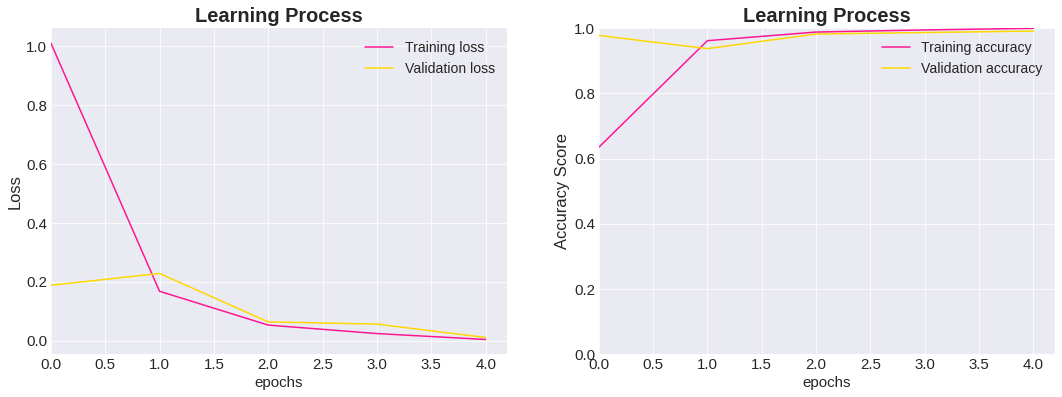

In [19]:
plt.style.use('seaborn-darkgrid')
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(18,6))
axs[0].plot(history.history['loss'], color='deeppink', label='Training loss')
axs[0].plot(history.history['val_loss'], color='gold', label='Validation loss')    
axs[0].set_title('Learning Process', fontsize=20, fontweight='heavy')
axs[0].set_xlabel('epochs', fontsize=15)
axs[0].set_ylabel('Loss', fontsize=16.5)
axs[0].tick_params(axis='both', labelsize=15)
axs[0].legend(loc='best', shadow=True, prop={'size': 14})
axs[0].set_xlim(left=0)
axs[1].plot(history.history['accuracy'], color='deeppink', label='Training accuracy')
axs[1].plot(history.history['val_accuracy'], color='gold', label='Validation accuracy')
axs[1].set_title('Learning Process', fontsize=20, fontweight='heavy')
axs[1].set_xlabel('epochs', fontsize=15)
axs[1].set_ylabel('Accuracy Score', fontsize=16.5)
axs[1].set_ylim(0,1)
axs[1].tick_params(axis='both', labelsize=15)
axs[1].legend(loc='best', shadow=True, prop={'size': 14})
axs[1].set_xlim(left=0)

## Evaluation

In [20]:
preds = model.predict(padded_seq_sentence_test)
preds_lbl = [np.argmax(pred)-1 for pred in preds] 
act_lbl = [x-1 for x in label_test_seq]

Text(31.5, 0.5, 'Actual')

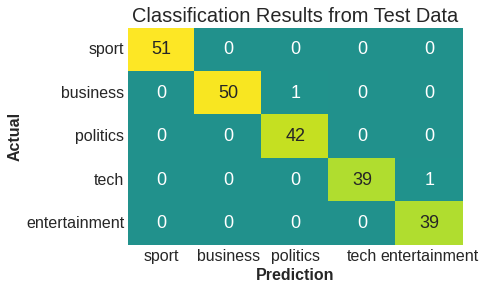

In [21]:
g_cm = sns.heatmap(cm(act_lbl, preds_lbl), annot=True ,fmt='d',cbar=False, cmap='viridis',
                    center=0, annot_kws={'size': 18}, 
                  )

g_cm.set_xticklabels(lbl, fontsize=16) 
g_cm.set_yticklabels(lbl, fontsize=16, rotation=0) 
plt.title('Classification Results from Test Data', fontsize=20)
plt.xlabel('Prediction', fontsize=16, fontweight='bold')
plt.ylabel('Actual', fontsize=16, fontweight='bold') 

In [22]:
print(cr(act_lbl, preds_lbl))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        51
           1       1.00      0.98      0.99        51
           2       0.98      1.00      0.99        42
           3       1.00      0.97      0.99        40
           4       0.97      1.00      0.99        39

    accuracy                           0.99       223
   macro avg       0.99      0.99      0.99       223
weighted avg       0.99      0.99      0.99       223



## Save Model

In [23]:
# define dir for saving
my_dir = '/drive/MyDrive/Colab/Project/'

# saving tokenizer
with open(my_dir+'tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving training setting
training_setting = {
    'vocab_size' : vocab_size,
    'embedding_dim' : embedding_dim,
    'max_length' : max_length,
    'padding_type' : padding_type,
    'trunc_type' : trunc_type,
    'oov_tok' : oov_tok
}
with open(my_dir+'training_setting.pkl', 'wb') as handle:
    pickle.dump(training_setting, handle, protocol=pickle.HIGHEST_PROTOCOL)

# saving model
model.save(my_dir+'news_cat_model.h5')

# Test Prediction


In [24]:
# load tokenizer
with open(my_dir+'tokenizer.pkl', 'rb') as handle:
    tokenizer_ = pickle.load(handle)

# load training setting
with open(my_dir+'training_setting.pkl', 'rb') as handle:
    training_setting = pickle.load(handle)

# load model
savedModel=load_model(my_dir+'news_cat_model.h5')
savedModel.summary()

Model: "Simple_NLP_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 883, 213)          1210692   
                                                                 
 bidirectional (Bidirectiona  (None, 883, 100)         105600    
 l)                                                              
                                                                 
 global_average_pooling1d (G  (None, 100)              0         
 lobalAveragePooling1D)                                          
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense (Dense)               (None, 6)                 606       
                                                                 
Total params: 1,316,898
Trainable params: 1,316,89

## Test 1

In [25]:
sentence_input = '''
Singapura - Timnas Indonesia lolos ke semifinal Piala AFF 2020. Skuad Garuda meraih tiketnya setelah menghajar Malaysia dengan skor akhir 4-1.
Di National Stadium, Minggu (19/12/2021) malam WIB, Indonesia mampu comeback saat melawan Malaysia. Ketinggalan lebih dulu akibat gol Kogeliswaran Raj.

Di sisa pertandingan Indonesia membalas empat kali lewat Irfan Jaya (dua gol), satu gol Pratama Arhan serta Elkan Baggott. Indonesia lolos ke babak 4 besar dengan meyakinkan.

Dengan hasil ini, Indonesia menjadi juara Grup B dengan raihan 10 poin. Indonesia unggul produktivitas gol dari Vietnam hingga finis teratas, Malaysia finis ketiga dengan raihan 6 poin.

Indonesia akan melawan Singapura di babak semifinal, pertandingan leg 1 akan berlangsung pada 22 Desember.

Jalannya Pertandingan

Indonesia unggul 2-1 atas Malaysia di babak pertama. Skuad Garuda ketinggalan lebih dulu pada menit ke-13. Tendangan Kogeliswaran Raj yang bersarang ke gawang Indonesia.

Setelah kebobolan, Indonesia tersengat. Di situs resmi turnamen, ada 15 percobaan tim asuhan Shin Tae-yong yang 5 di antaranya mencapai sasaran.

Gol penyama kedudukan Indonesia hadir pada menit ke-36. Umpan dari Witan Sulaeman diselesaikan oleh Irfan Jaya.

Indonesia berbalik unggul pada menit ke-43. Tendangan Pratama Arhan membentur pemain belakang Malaysia, bola di muka gawang disambar oleh Irfan Jaya! Indonesia unggul 2-1!

Elkan Baggott dimasukkan oleh Shin Tae-yong di babak kedua. Dia menggantikan Ramai Rumakiek. Indonesia memainkan 3 bek di babak kedua.

Tendangan keras Arhan gol! Umpan dari Irfan Jaya diselesaikan Arhan dengan tendangan jarak jauh yang menghujam deras ke gawang Malaysia di menit ke-50.

Indonesia nyaris menambah gol di menit ke-55. Tendangan Irfan Jaya meneruskan umpan Rachmat Irianto masih menyamping.

Gol Malaysia di menit ke-59 dianulir. Muhammad Syafiq menyarangkan bola, tapi sebelumnya ada pelanggaran dari Dion Cools pada Nadeo.

Indonesia mendapay peluang pada menit ke-70. Dominic Tan melanggar Irfan Jaya, berbuah tendangan bebas untuk Indonesia di daerah permainan Malaysia, eksekusinya bisa diantisipasi pemain Malaysia, berbuah tendangan sudut.

Pergantian pemain dilakukan Shin Tae-yong pada menit ke-75. Evan Dimas Darmono dimasukkan, menggantikan Rachmat Irianto.

Indonesia nyaris bikin gol di menit ke-80. Bola sodoran Witan Sulaeman mengarahke Kushedya Hari Yudo, bolanya bisa disapu pemain belakang Malaysia.

Gol keempat Indonesia hadir dari Elkan Baggott. Umpan tendangan sudut Evan Dimas bisa diselesaikan oleh Elkan menjadi gol pada menit ke-82.


Susunan Pemain

Indonesia: 1 Nadeo Argawinata, 12 Pratama Arhan, 14 Asnawi Mangkualam, 28 Alfeandra Dewangga, 19 Fachruddin Ariyanto, 13 Rachmat Arianto (6 Evan Dimas 75), 15 Ricky Kambuaya, 8 Witan Sulaeman, 20 Ramai Rumaikiek (Elkan Baggott 46), 25 Irfan Jaya (Yabes Roni 92), 7 Ezra Walian (Hari Yudo 64) (Hanis Sagara 92)

Malaysia: 21 Khairul Fahmi, 2 Dion Cools, 4 Muhammad Syami, 5 Putera Nadher Amarhan, 16 Mohd Rizal, 8 Baddrol, 13 Arif Aiman, 15 Kogeliswaran Raj (9 De paul 60), 24 Mohamad Faisal, 20 Muhammad Syafiq (Sharel Fikri 77), 11 Safawi Rasid (Dominic Tan 46)

'''

Source:  

* ["Piala AFF: Hajar Malaysia 4-1, Indonesia ke Semifinal"](https://sport.detik.com/sepakbola/liga-indonesia/d-5862021/piala-aff-hajar-malaysia-4-1-indonesia-ke-semifinal)

In [32]:
lang = langdetect.detect(sentence_input)

print(lang)
if lang!='en':  
  sentence_input = Translator().translate(sentence_input).text

sentence_input_prep = [sentence_input]
seq = tokenizer_.texts_to_sequences(sentence_input_prep)
pad = pad_sequences(seq, padding=training_setting['padding_type'], 
                    truncating=training_setting['trunc_type'], 
                    maxlen=training_setting['max_length']) 
pred = savedModel.predict(pad)
pred_lbl = lbl[np.argmax(pred)-1]

print('Input: \n\t{}'.format(sentence_input))
print('---')
print('Input to Sequence: \n\t{}'.format(seq[0]))
print('---')
print('Padded Sequence: \n\t{}'.format(pad[0]))
print('Padded Sequence (Text Form): \n\t{}'.format(decode_article(pad[0])))
print('---\n')
print('Prediction: {}'.format(pred_lbl))

en
Input: 
	Singapore - The Indonesian national team qualified for the AFF 2020 Cup semifinals. Garuda's squad won the ticket after beating Malaysia with a final score of 4-1.
At the National Stadium on Sunday (12/19/2021) night WIB, Indonesia was able to comeback against Malaysia. Look first due to the goal of Kogeliswaran Raj.

In the remaining match Indonesia replied four times through Irfan Jaya (two goals), one goal Pratama Arhan and Ekk Baggott. Indonesia qualified for the last 4 of convincingly.

With this result, Indonesia won Group B with 10 points. Indonesia Superior productivity Goals from Vietnam to top finish, Malaysia finished third with 6 points.

Indonesia will fight Singapore in the semifinals, the 1-leg match will take place on December 22.

The course of the match

Indonesia won 2-1 over Malaysia in the first round. Garuda's squad left first in the 13th minute. Kogeliswaran Kogelaran Raj who lodged into the Indonesian goal.

After conceding, Indonesia was stung. On t

## Test 2

In [33]:
sentence_input_2 = '''
(CNN) - Tom Holland is a man of his word.

He promised a little boy who saved his sister from a dog attack in 2020 that the young Spider-Man fan could visit the "Spider-Man: No Way Home" set and he did just that.

Bridger Walker was just 6 years old when he jumped into action to save his 4-year-old sister. The siblings were playing outside their Wyoming home when a German shepherd mix charged toward Walker's sister and he intervened. He subsequently underwent a two-hour surgery that required more than 90 stitches, according to his family in a statement to CNN at the time of the July 2020 incident.

Celebrities like Anne Hathaway, Chris Evans, Mark Ruffalo and Holland sent messages both on social media and privately to Walker, praising him for his courage. Holland invited him to do some real-life web slinging.
Walker's father shared images and a video from the set visit. In one post, Walker is seen doing a stunt with Holland who is dressed in his Spider-Man suit.

'''

Source:  

* ["Tom Holland makes good on his promise to boy who saved his sister from dog attack"](https://edition.cnn.com/2021/12/21/entertainment/bridger-walker-spider-man-set-tom-holland/index.html)

In [34]:
lang_2 = langdetect.detect(sentence_input_2)

print(lang_2)
if lang_2!='en':  
  sentence_input_2 = Translator().translate(sentence_input_2).text

sentence_input_prep_2 = [sentence_input_2]
seq_2 = tokenizer_.texts_to_sequences(sentence_input_prep_2)
pad_2 = pad_sequences(seq_2, padding=training_setting['padding_type'], 
                      truncating=training_setting['trunc_type'],
                      maxlen=training_setting['max_length']) 
pred_2 = savedModel.predict(pad_2)
pred_lbl_2 = lbl[np.argmax(pred_2)-1]

print('Input: \n\t{}'.format(sentence_input_2))
print('---')
print('Input to Sequence: \n\t{}'.format(seq_2[0]))
print('---')
print('Padded Sequence: \n\t{}'.format(pad_2[0]))
print('Padded Sequence (Text Form): \n\t{}'.format(decode_article(pad_2[0])))
print('---\n')
print('Prediction: {}'.format(pred_lbl_2))

en
Input: 
	
(CNN) - Tom Holland is a man of his word.

He promised a little boy who saved his sister from a dog attack in 2020 that the young Spider-Man fan could visit the "Spider-Man: No Way Home" set and he did just that.

Bridger Walker was just 6 years old when he jumped into action to save his 4-year-old sister. The siblings were playing outside their Wyoming home when a German shepherd mix charged toward Walker's sister and he intervened. He subsequently underwent a two-hour surgery that required more than 90 stitches, according to his family in a statement to CNN at the time of the July 2020 incident.

Celebrities like Anne Hathaway, Chris Evans, Mark Ruffalo and Holland sent messages both on social media and privately to Walker, praising him for his courage. Holland invited him to do some real-life web slinging.
Walker's father shared images and a video from the set visit. In one post, Walker is seen doing a stunt with Holland who is dressed in his Spider-Man suit.


---
Inpu